In [22]:
import os, sys, time, shutil, pdb, argparse,json, glob
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.double)
from botorch.utils.transforms import normalize, unnormalize
from botorch.utils.sampling import draw_sobol_samples
from activephasemap.models.np import NeuralProcess
from activephasemap.models.gp import MultiTaskGP
from gpytorch.distributions import MultivariateNormal as mvn

In [23]:
TARGET_SHAPE = "triangle" # chose from ["sphere", "triangle"]
NUM_RESTARTS = 1

gp_model_args = {"model":"gp", "num_epochs" : 1, "learning_rate" : 1e-3, "verbose": 1}
DATA_DIR = '../04012024/6D/output'
ITERATION = len(glob.glob("../04012024/6D/data/spectra_*.npy"))
with open('../04012024/best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]
DESIGN_SPACE_DIM = 5
design_space_bounds = [(0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0),
                       (0.0, 75.0), 
                       (0.0, 11.0),
                       ]
bounds = torch.tensor(design_space_bounds).transpose(-1, -2).to(device)

# Create a target spectrum
target = np.load("../04012024/6D/data/target_%s.npz"%TARGET_SHAPE)
wav = target["x"]
n_domain = len(wav)
t = (wav-min(wav))/(max(wav)-min(wav))
xt = torch.from_numpy(t).to(device).view(1, n_domain, 1)
yt = torch.from_numpy(target["y"]).to(device).view(1, n_domain, 1)

# Load GP and NP models and set them to evaluation mode
train_x = torch.load(DATA_DIR+'/train_x_%d.pt'%ITERATION, map_location=device)
train_y = torch.load(DATA_DIR+'/train_y_%d.pt'%ITERATION, map_location=device)
train_y_std = 0.1*torch.ones_like(train_y)
normalized_x = normalize(train_x, bounds).to(train_x)
print(normalized_x.max(), normalized_x.min())
GP = MultiTaskGP(normalized_x, train_y, gp_model_args, DESIGN_SPACE_DIM, N_LATENT, train_y_std)
gp_state_dict = torch.load(DATA_DIR+'/gp_model_%d.pt'%ITERATION, map_location=device)
GP.load_state_dict(gp_state_dict)
GP.train(False)

NP = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
NP.load_state_dict(torch.load(DATA_DIR+'/np_model_%d.pt'%ITERATION, map_location=device)) 
NP.train(False)

tensor(1.) tensor(0.)


NeuralProcess(
  (xy_to_r): Encoder(
    (input_to_hidden): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=128, out_features=16, bias=True)
    )
  )
  (r_to_mu_sigma): MuSigmaEncoder(
    (r_to_hidden): Linear(in_features=16, out_features=16, bias=True)
    (hidden_to_mu): Linear(in_features=16, out_features=4, bias=True)
    (hidden_to_sigma): Linear(in_features=16, out_features=4, bias=True)
  )
  (xz_to_y): Decoder(
    (xz_to_hidden): Sequential(
      (0): Linear(in_features=5, out_features=128, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): Sigmoid()
    )
    (hidden_to_mu): Linear(in_features=128, out_features=1, bias=True)
    (hidden_to_sigma): Linear(in_features=128, out_

In [24]:
comps = np.load("../04012024/6D/data/comps_7.npy")
rid = np.random.randint(comps.shape[0], size=NUM_RESTARTS)
X = torch.from_numpy(comps[rid])

In [25]:
X = draw_sobol_samples(bounds=bounds, n=NUM_RESTARTS, q=1).to(device).squeeze(0)

In [26]:
def from_comp_to_spectrum(gp_model, np_model, t, c, bounds):
    gp_model.eval()
    normalized_x = normalize(c, bounds)
    posterior = gp_model.posterior(normalized_x)
    mu = []
    for _ in range(100):
        z = posterior.rsample().squeeze(0)
        mu_i, _ = np_model.xz_to_y(t, z)
        mu.append(mu_i)

    mean_pred = torch.cat(mu).mean(dim=0, keepdim=True)
    sigma_pred = torch.cat(mu).std(dim=0, keepdim=True)

    return mean_pred, sigma_pred 

In [27]:
num_points, dim = X.shape 
spectra_pred = torch.zeros((num_points, n_domain, 2)).to(device)
mu_mat = torch.zeros((num_points, n_domain)).to(device)
cov_mat = torch.zeros((num_points, n_domain, n_domain)).to(device)
for i in range(num_points):
    ci = X[i,:].reshape(1, DESIGN_SPACE_DIM)
    mu, sigma = from_comp_to_spectrum(GP, NP, xt, ci, bounds)
    spectra_pred[i,:, 0] = mu.squeeze()
    spectra_pred[i,:, 1] = sigma.squeeze()
    cov_mat[i,...] = torch.eye(n_domain)*sigma.squeeze()

target = yt.squeeze().repeat(num_points, 1)

dist = mvn(spectra_pred[i,:, 0], cov_mat)
loss = dist.log_prob(target)

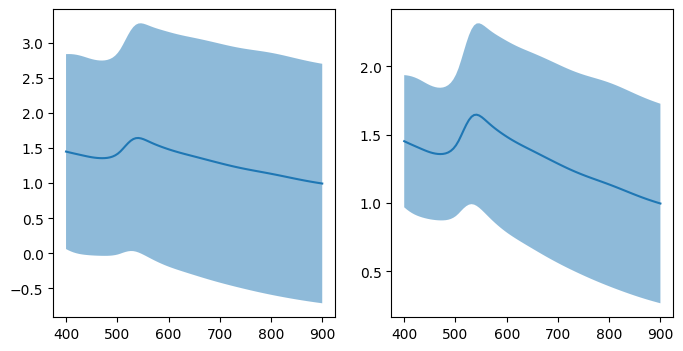

In [28]:
with torch.no_grad():
    fig, axs = plt.subplots(1,2, figsize=(4*2, 4*1))
    ax = axs[0]
    lower, upper = dist.confidence_region()
    ax.plot(wav, dist.mean.numpy().squeeze())
    ax.fill_between(wav, 
                    lower.numpy().squeeze(), 
                    upper.numpy().squeeze(),
                    alpha=0.5
                    )
    
    ax = axs[1]
    mu = spectra_pred[...,0].squeeze()
    sigma = spectra_pred[...,1].squeeze()
    ax.plot(wav, mu)
    ax.fill_between(wav,
                    mu-sigma, 
                    mu+sigma,
                    alpha=0.5
                    )    
    plt.show()